In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl

import sys

sys.path.append('../../helper_classes')
from limit_utils import get_sensitivity_bands

2025-05-30 02:16:23.220872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748596583.237969  494695 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748596583.243240  494695 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748596583.259187  494695 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748596583.259202  494695 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748596583.259204  494695 computation_placer.cc:177] computation placer alr

In [2]:
def get_signal_rates_from_likelihood(likelihood_file):
    sys.path.append('..')
    likelihood_class = __import__('create_simple_template_likelihood', globals(), locals(), [])
    class_names = [name for name in dir(likelihood_class) if isinstance(getattr(likelihood_class, name), type)]
    globals().update({name: getattr(likelihood_class, name) for name in class_names})
    
    likelihood_container = pkl.load(open(likelihood_file, 'rb'))
    signal_expected_mean = likelihood_container.expected_signal_counts
    
    return signal_expected_mean

In [3]:
def scaling_fn(mu, mu_ref):
    return mu / mu_ref * 1e-45

In [4]:
signal_expected_mean = get_signal_rates_from_likelihood('../wimp_sensitivity/likelihoods/SI_60t_benchmark_0.61.pkl')

In [5]:
masses, bands = get_sensitivity_bands(directory='../wimp_sensitivity/outputs/SI_60t_benchmark_0.61',
                                      scaling_fn=scaling_fn,
                                      signal_name='WIMP',
                                      signal_expected_mean=signal_expected_mean,
                                      inference_config='../wimp_sensitivity/inference_configs/SI_WIMP_benchmark.ini')

Found 110 failed toy for WIMP10; removing...
Found 257 failed toy for WIMP60; removing...
Found 331 failed toy for WIMP1000; removing...


1 sigma band for 0: [np.float64(6.0795877617654235e-49), np.float64(3.12857162428886e-48)]
2 sigma band for 0: [np.float64(8.761199847790158e-49), np.float64(2.5066846823630764e-48)]
1 sigma band for 1: [np.float64(6.655698850413837e-50), np.float64(2.7512428932830516e-49)]
2 sigma band for 1: [np.float64(9.273870606077461e-50), np.float64(2.276449337076889e-49)]
1 sigma band for 2: [np.float64(8.377680778168075e-49), np.float64(3.1647446748570675e-48)]
2 sigma band for 2: [np.float64(1.1843653374193385e-48), np.float64(2.6994045216319076e-48)]


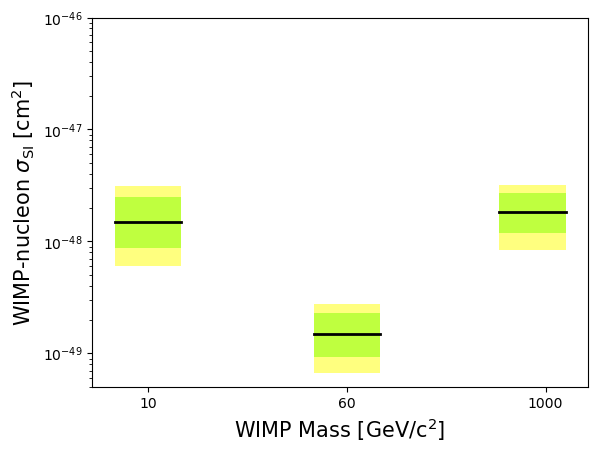

In [6]:
fig = plt.figure()
ax = fig.gca()
delta = 0.05

ticks_plot = {0.2: 0,
              0.5: 1,
              0.78: 2}
for tick, i in ticks_plot.items():

    plt.plot([tick-delta, tick+delta],
             2*[bands[0][i]],
             color='k', linewidth=2)
    plt.fill_between([tick-delta, tick+delta],
                     2*[bands[-1][i]], 2*[bands[1][i]],
                     facecolor='#00ff00', alpha=0.5) #green # 1 sigma

    plt.fill_between([tick-delta, tick+delta],
                     2*[bands[-2][i]], 2*[bands[2][i]],
                     facecolor='#ffff00', alpha=0.5) #yellow # 2 sigma
    print(f"1 sigma band for {i}: {[bands[-2][i], bands[2][i]]}")
    print(f"2 sigma band for {i}: {[bands[-1][i], bands[1][i]]}")
    

xlab = r'WIMP Mass [GeV/c$^2$]'
ax.set_xlabel(xlab, fontsize=15)
plt.xticks([0.2, 0.5, 0.8], labels=[10, 60, 1000])

ylab = r'WIMP-nucleon $\sigma_{\rm SI}$ [cm$^2$]'
ylim = (5e-50, 1e-46)
ax.set_ylabel(ylab, fontsize=15)
ax.set_ylim(ylim)

ax.set_yscale('log')

In [7]:
print(bands)

{0: [np.float64(1.488435950308984e-48), np.float64(1.484214750536932e-49), np.float64(1.8423487039581437e-48)], -1: [np.float64(8.761199847790158e-49), np.float64(9.273870606077461e-50), np.float64(1.1843653374193385e-48)], 1: [np.float64(2.5066846823630764e-48), np.float64(2.276449337076889e-49), np.float64(2.6994045216319076e-48)], -2: [np.float64(6.0795877617654235e-49), np.float64(6.655698850413837e-50), np.float64(8.377680778168075e-49)], 2: [np.float64(3.12857162428886e-48), np.float64(2.7512428932830516e-49), np.float64(3.1647446748570675e-48)]}


In [8]:
print(bands[-1][0],bands[1][0], '1 sig')

print(bands[-2][0], bands[2][0], '2 sig')

8.761199847790158e-49 2.5066846823630764e-48 1 sig
6.0795877617654235e-49 3.12857162428886e-48 2 sig


'bands[0]' are the medians. 'bands[1&-1]' are our quartiles.

The code below saves the sensitivities into a .txt file for each WIMP mass. Everytime you run it, it adds a new row to each file.

In [9]:
# Text file names per band key
band_names = {
    0: "sensitivity",
    -1: "1_sigma_lower",
    1: "1_sigma_upper",
    -2: "2_sigma_lower",
    2: "2_sigma_upper"
}

column_headers = ["10 GeV", "60 GeV", "1000 GeV"]

output_folder = "band_outputs"

os.makedirs(output_folder, exist_ok=True)

# Save each band's values to its own file
for band_key, values in bands.items():
    title = band_names.get(band_key, "")
    filename = f"{title}.txt"
    filepath = os.path.join(output_folder, filename)
    file_exists = os.path.isfile(filepath)

    with open(filepath, "a") as file:
        # Write header if file is new
        if not file_exists:
            file.write("\t".join(column_headers) + "\n")
        # Write the data row
        file.write("\t".join(f"{v:.18e}" for v in values) + "\n")